In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import os

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format = "retina"
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

In [2]:
# !pip install lsdb

In [3]:
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata

'Version of lsdb is %s' % lsdb.__version__

'Version of lsdb is 0.2.3.dev6+gb532108'

In [4]:
# Gaia
gaia_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia"

# ZTF
ztf_object_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/"
ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_zource/"

In [5]:
%%time

# Load lite (coarse) version of Gaia DR3 (it has data from all the HEALPix intersecting with the cone)
cone_search = ConeSearch(ra=-60, dec=20, radius_arcsec=1*3600)
gaia_lite = lsdb.read_hipscat(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load Gaia data for the same cone (keeps only data inside the cone)
gaia = lsdb.read_hipscat(gaia_path).cone_search(ra=-60, dec=20, radius_arcsec=1*3600, fine=True)

CPU times: user 462 ms, sys: 131 ms, total: 593 ms
Wall time: 12.2 s


In [6]:
list(read_parquet_metadata(os.path.join(gaia_path, "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _hipscat_index
   path: _hipscat_index
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: Int(bitWidth=64, isSigned=false)
   converted_type (legacy): UINT_64,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

In [7]:
gaia_lite_computed = gaia_lite.compute()

In [8]:
gaia_lite

,ra,dec
npartitions=6,,
3643412098542731264,double[pyarrow],double[pyarrow]
3644537998449573888,...,...
...,...,...
3653545197704314880,...,...
18446744073709551615,...,...


In [9]:
gaia_lite_computed

,ra,dec
_hipscat_index,,
3643412099679387648,300.938807,16.959530
3643412100069457920,300.939196,16.960282
3643412100413390848,300.938070,16.960664
3643412102065946624,300.938019,16.961057
3643412107736645632,300.934457,16.961220
...,...,...
3654671088115253248,299.533488,23.313408
3654671088761176064,299.533875,23.314336
3654671089591648256,299.527580,23.311197


In [10]:
%%time
ztf_object = lsdb.read_hipscat(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 934 ms, sys: 258 ms, total: 1.19 s
Wall time: 17.5 s


In [11]:
ztf_object

,ra,dec
npartitions=2352,,
0,double[pyarrow],double[pyarrow]
18014398509481984,...,...
...,...,...
13830554455654793216,...,...
18446744073709551615,...,...


In [12]:
ztf_source

,ra,dec
npartitions=41679,,
0,double[pyarrow],double[pyarrow]
4503599627370496,...,...
...,...,...
13833932155375321088,...,...
18446744073709551615,...,...


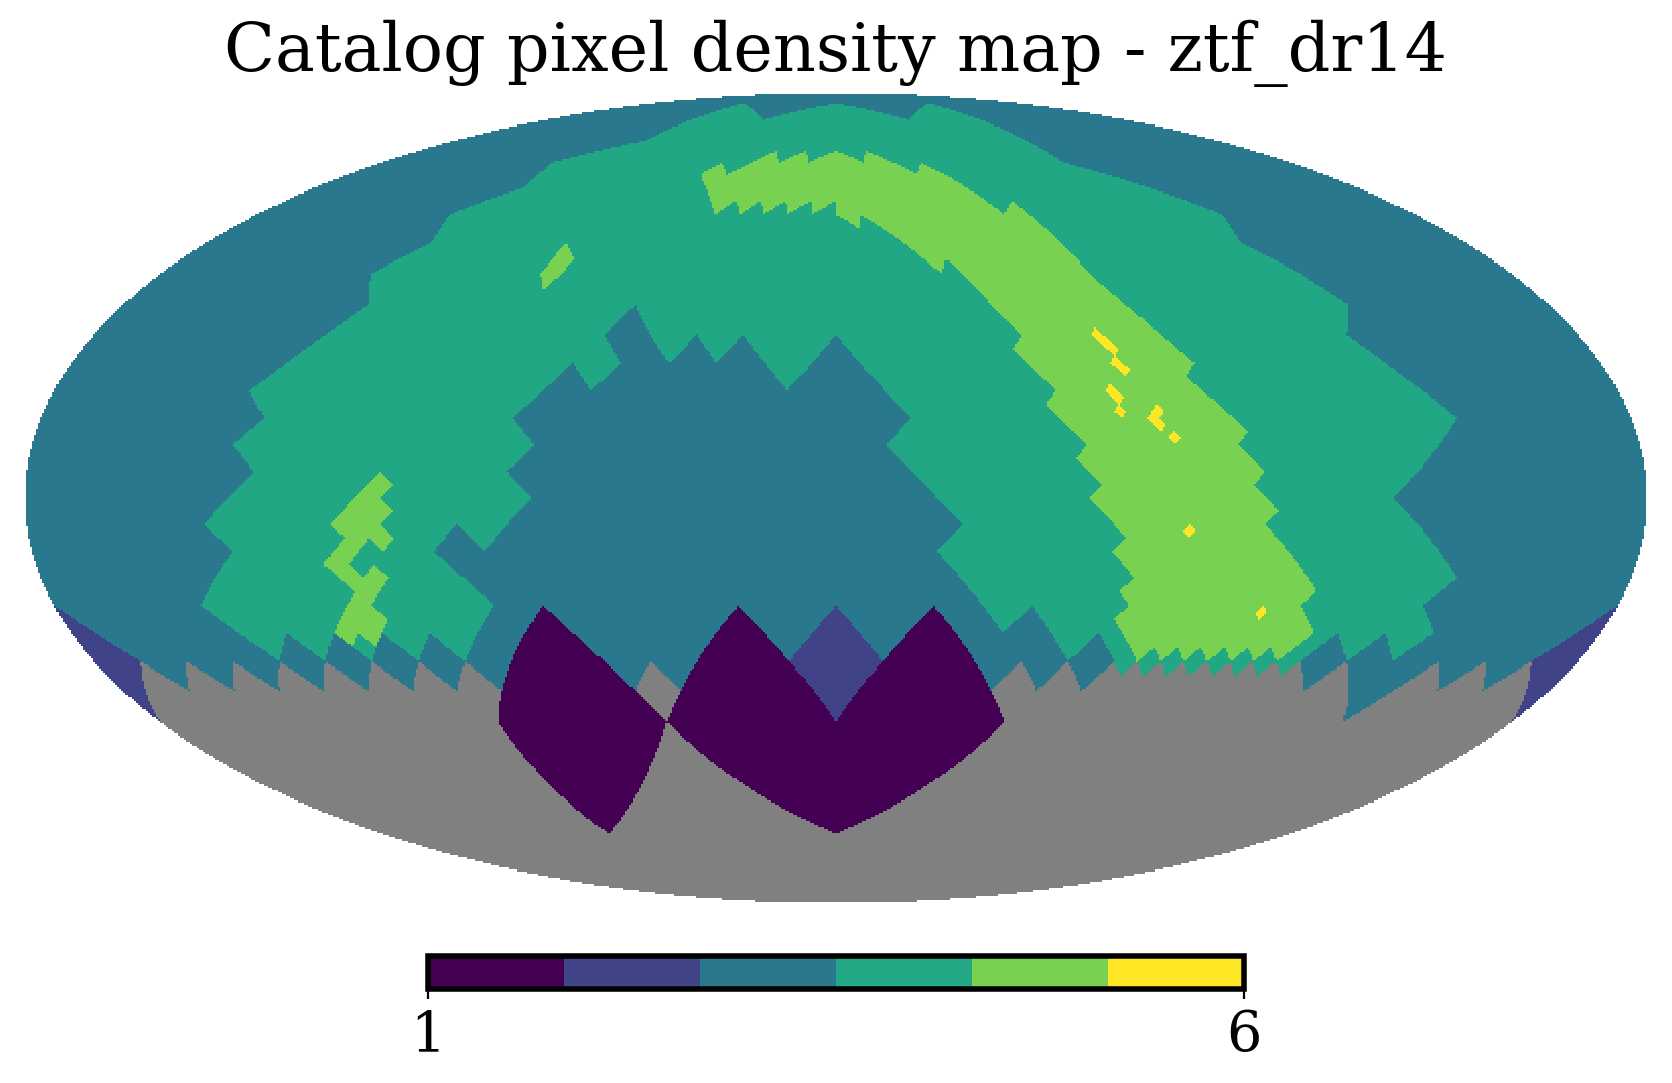

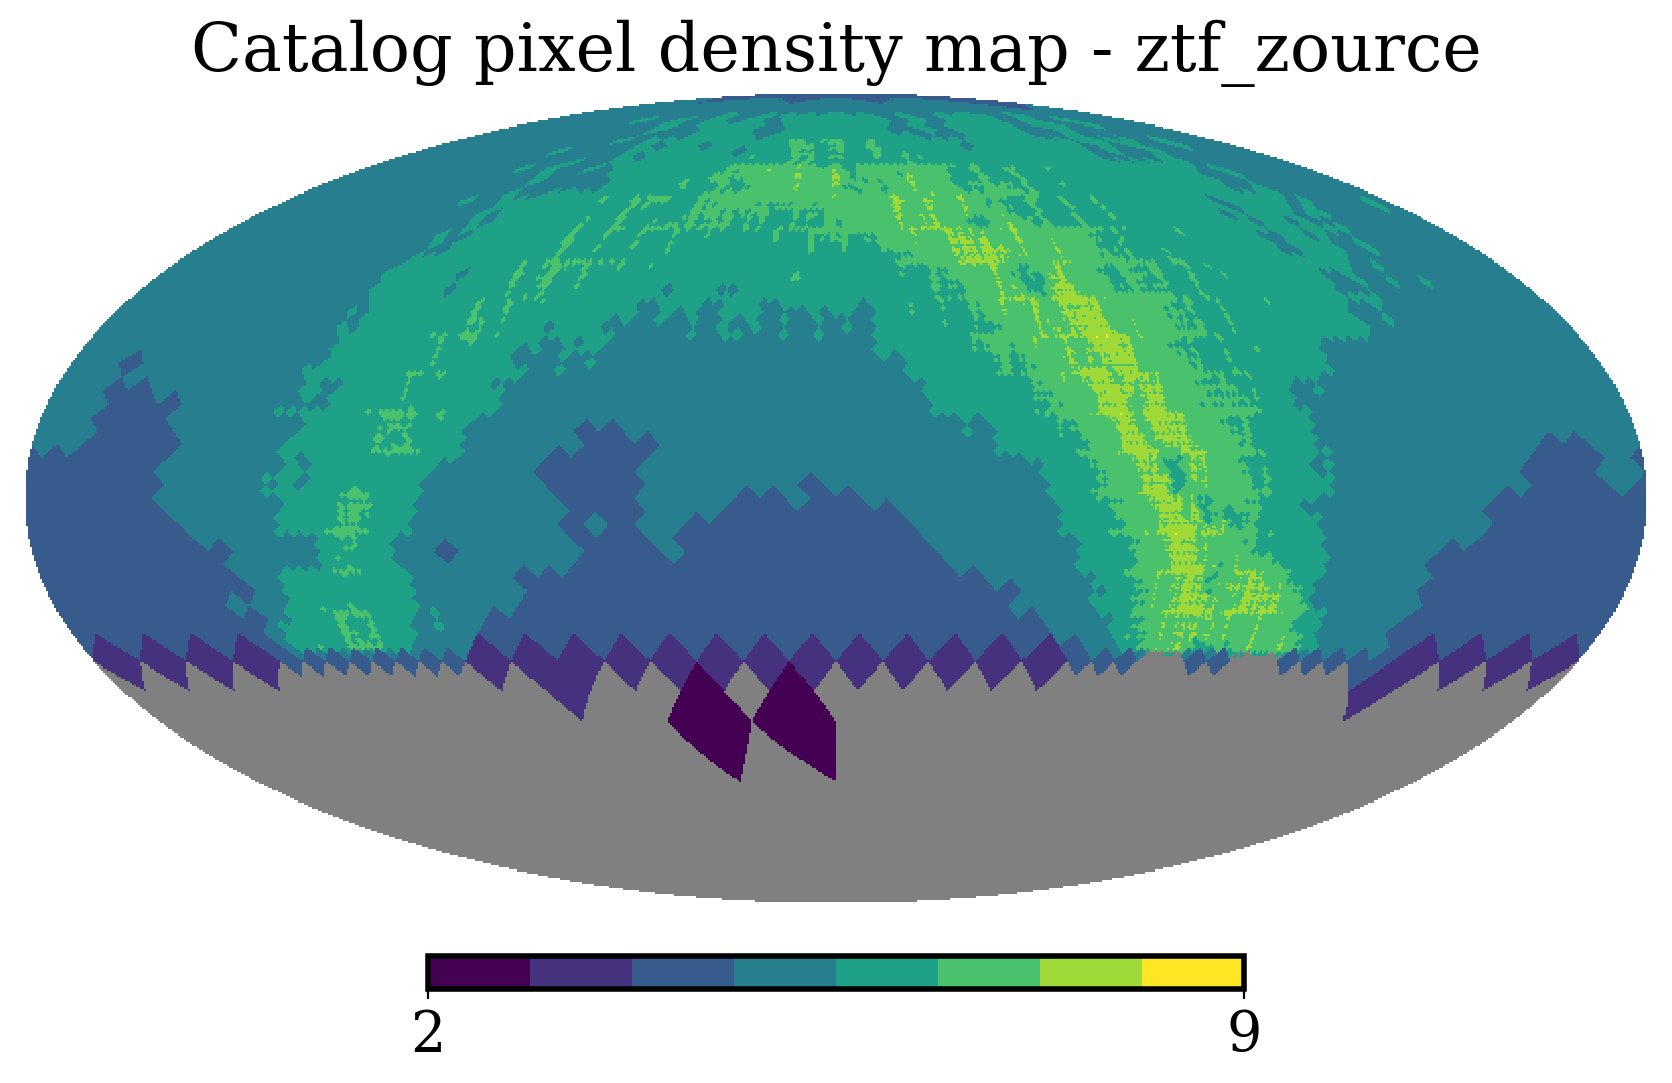

In [13]:
# Plot the Pixel Density Maps for Gaia and ZTF

#plot_pixels(gaia.hc_structure)
plot_pixels(ztf_object.hc_structure)
plot_pixels(ztf_source.hc_structure)

In [14]:
# Cross-match Gaia and ZTF
%time 
xmatch_object = gaia_lite.crossmatch(ztf_object)

xmatch_object.head(5)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


/Users/scampos/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_gaia,dec_gaia,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,
3643412099679387648,300.938807,16.959530,300.938812,16.959557,0.096993
3643412100069457920,300.939196,16.960282,300.939191,16.960302,0.076818
3643412100413390848,300.938070,16.960664,300.938068,16.960826,0.584654
3643412102065946624,300.938019,16.961057,300.938068,16.960826,0.846288
3643412107736645632,300.934457,16.961220,300.934442,16.961234,0.069840


In [15]:
# load the margins?

In [16]:
# Reading HiPSCat's from an 'almanac' ?

In [17]:
%%time
# load ZTF with all columns here
ztf_object_full = lsdb.read_hipscat(ztf_object_path)

CPU times: user 192 ms, sys: 55.3 ms, total: 248 ms
Wall time: 4.65 s


In [18]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 63.8 ms, sys: 6.24 ms, total: 70 ms
Wall time: 73.5 ms


/Users/scampos/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [19]:
%%time
total = _all_sky_object.compute()

CPU times: user 11.1 s, sys: 11.8 s, total: 22.9 s
Wall time: 3min 56s


In [20]:
total.head(5)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3645794894481457152,1636148068921376768,Gaia DR3 1822897438847444096,1822897438847444096,42581465,2016.0,299.958766,0.036376,19.015590,0.034388,0.425465,...,71,100,122,17.222887,16.625666,16.410654,5,0,3238,0.036928
3645795176636481536,1636148068921376768,Gaia DR3 1822897580605978368,1822897580605978368,1319303262,2016.0,299.989000,0.041975,19.036786,0.040406,0.438594,...,71,100,132,17.246981,16.712664,16.519144,5,0,3238,0.050803
3645795422233952256,1636148068921376768,Gaia DR3 1822897683685242496,1822897683685242496,697324102,2016.0,299.956489,0.027647,19.042023,0.026494,0.423969,...,568,887,138,16.638927,16.096959,15.908190,5,0,3238,0.078279
3645795527955578880,1636148068921376768,Gaia DR3 1822897752404725504,1822897752404725504,200327511,2016.0,299.955190,0.075366,19.049062,0.069169,0.801882,...,914,885,145,16.996378,16.391708,16.169791,5,0,3238,0.069556
3645795537183047680,1636148068921376768,Gaia DR3 1822897752404734720,1822897752404734720,312736557,2016.0,299.944745,0.030222,19.046157,0.028290,0.446037,...,577,885,143,16.741915,16.203624,16.042116,5,0,3238,0.068997


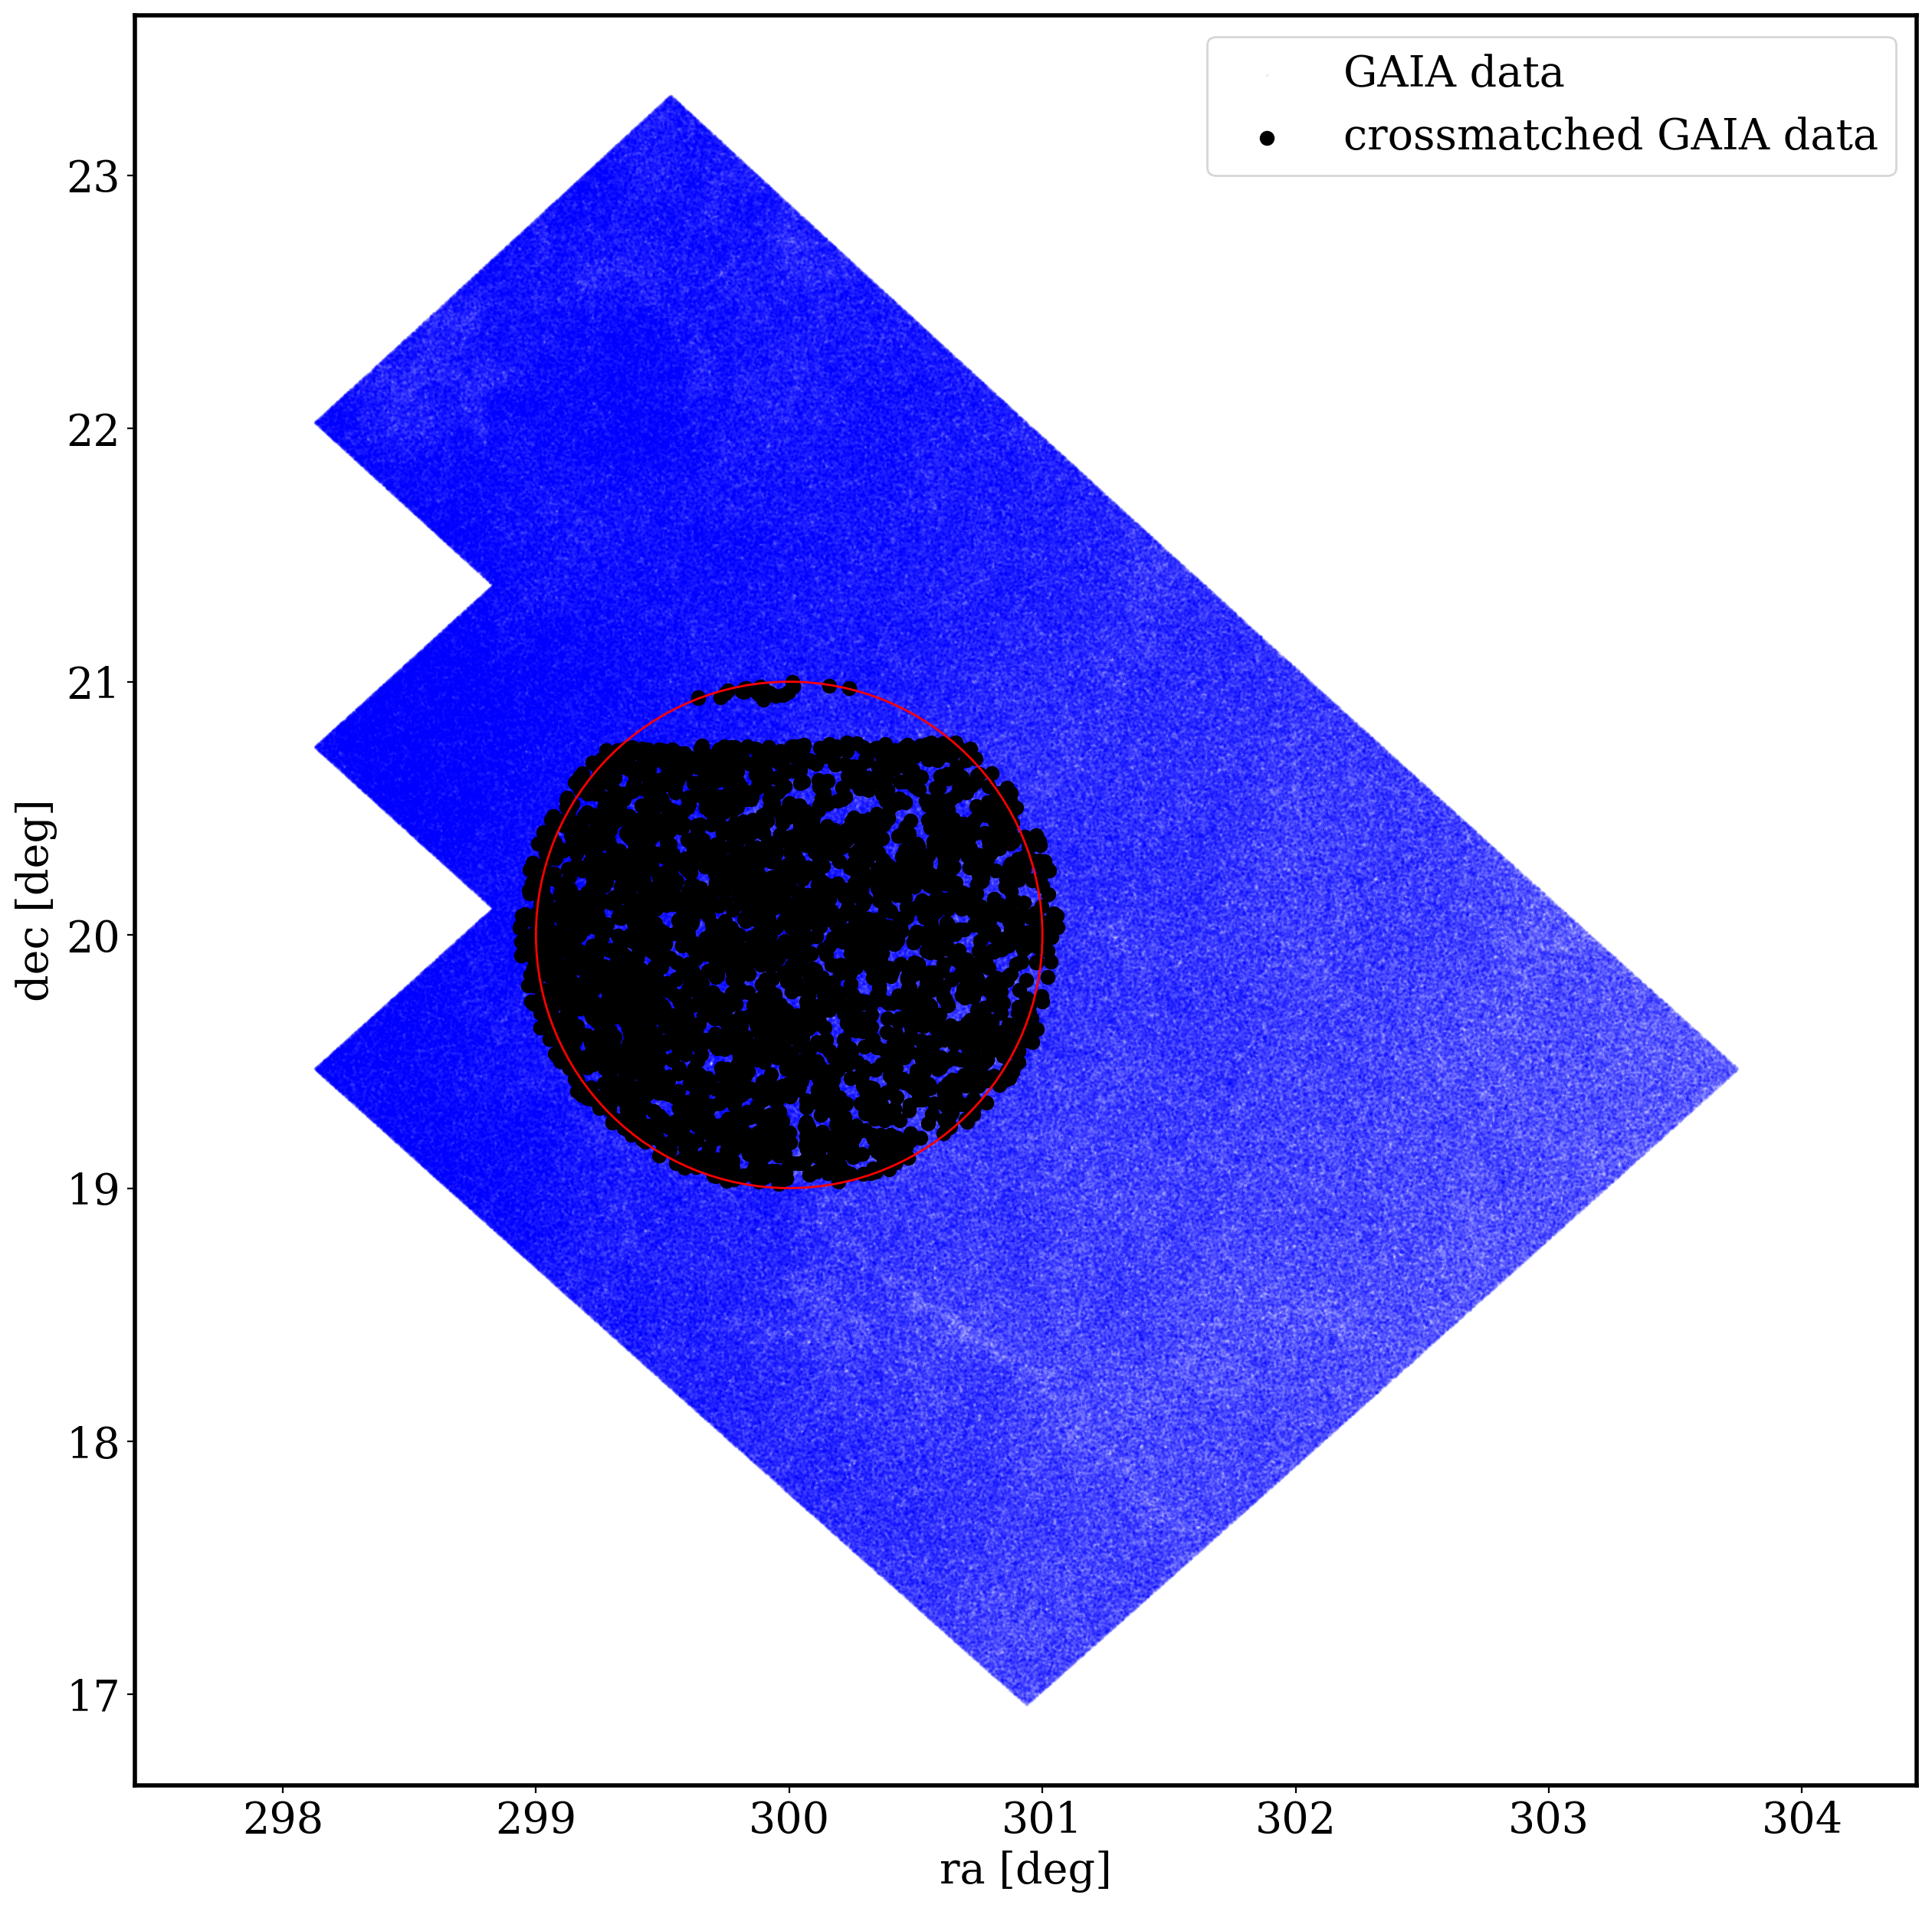

In [21]:
plt.figure(figsize=(15,15))

plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.1, alpha=0.1, label='GAIA data')
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', label='crossmatched GAIA data')
# Create a circle patch
circle = patches.Circle((300, 20), 1, edgecolor='red', facecolor='lightblue', fill=False)
plt.axis('equal')
# Use plt.gca() to get the current axes and add the circle to it
plt.gca().add_patch(circle)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

In [22]:
# export crossmatched data to disk
_all_sky_object.to_hipscat(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")